In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='white', palette='Dark2', font_scale=0.8)

### Loading the data

In [5]:
file_ = './main_table_of_Fourches_ligs_ERK2.pkl'
with open(file_, 'rb') as f:
    df_erk2_mols = pickle.load(f)
df_erk2_mols = df_erk2_mols.set_index('Name')
df_erk2_mols = df_erk2_mols.sort_values('pKi', ascending = False)

#### Get the names of each one of the precomputed descriptors

In [15]:
from rdkit.Chem import Descriptors
# MNQ descriptor's set goes from 1 to 42
names_MQN = ['MQN' + str(i) for i in range(1, 43)]

# Names of default included descriptors; fragment (fr_) descriptors ommited 
names_rdkit_descriptors_default = [x[0] for x in Descriptors._descList if x[0][:3] != 'fr_']
# Now concatenate the lists of names
names_all_rdkit_descriptors = names_rdkit_descriptors_default + ['CalcNumAtomStereoCenters',
                                'CalcNumUnspecifiedAtomStereoCenters',
                                'GetNumAtoms'] + names_MQN

print('Number of 2D RDKit descriptors', len(names_all_rdkit_descriptors))

Number of 2D RDKit descriptors 160


### Extract the set of descriptors from the main data table 

In [21]:
d = df_erk2_mols['2d_rdkit'].map(lambda x: x)
df_rdkit_all = pd.DataFrame.from_dict(dict(zip(d.index, d.values))).T
df_rdkit_all.columns = names_all_rdkit_descriptors
df_rdkit_all.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
CSAR_erk2_18,12.715656,-0.475203,12.715656,0.182531,0.492792,393.491,366.275,393.216475,152.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
erk2_54,13.405604,-0.745597,13.405604,0.083856,0.327709,459.308,442.172,458.071259,158.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
CSAR_erk2_20,12.732601,-0.584261,12.732601,0.017665,0.346052,443.935,417.727,443.172417,164.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
CSAR_erk2_17,12.673357,-3.485752,12.673357,0.055118,0.318735,464.935,443.767,464.103352,164.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
erk2_52,12.796961,-0.485488,12.796961,0.191864,0.321240,441.535,414.319,441.216475,168.0,0.0,...,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


### Use PCA to start the EDA: 
#### Just for visualization purposes before preprocessing and feature selection

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA(n_components=2)
pca_pipe = Pipeline(steps = [('scaler', scaler), ('pca', pca)])

X_rdk2d = df_rdkit_all
pca_pipe.fit(X_rdk2d)
# Components
components = pca_pipe.transform(X_rdk2d).T
# Variance ratio
var_ = pca_pipe['pca'].explained_variance_ratio_.round(3) * 100

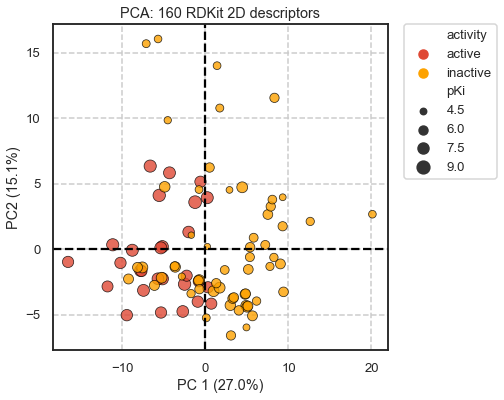

In [62]:
# Create a dataframe to plot the values
df_pca = df_erk2_mols[['activity', 'pKi']].copy()
df_pca['activity'] = ['active' if i else 'inactive' for i in df_pca.activity]
df_pca['pc1'] = components[0]
df_pca['pc2'] = components[1]

# Plot the PCS
fig, ax = plt.subplots(figsize=(6, 6))
ax.axvline(linestyle='--', color='k')
ax.axhline(linestyle='--', color='k')
sns.scatterplot(x='pc1', y='pc2', hue='activity', size='pKi', data=df_pca, 
                ax=ax, palette=['#df4834', '#fda200'], edgecolor='k', alpha=0.8)
ax.set(title='PCA: 160 RDKit 2D descriptors',
      xlabel=f'PC 1 ({var_[0]}%)', ylabel=f'PC2 ({var_[1]}%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='--')
plt.show()

### Feature Standarization

In [66]:
scaler = StandardScaler()
X_rdk2d_std = pd.DataFrame(scaler.fit_transform(X_rdk2d), columns=X_rdk2d.columns, index=X_rdk2d.index)
X_rdk2d_std

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
CSAR_erk2_18,0.203092,0.274699,0.203092,0.115122,0.149433,-0.311417,-0.452501,-0.306479,0.159179,0.0,...,-0.188982,0.0,-0.680972,-0.461774,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
erk2_54,0.677014,0.054409,0.677014,-0.617947,-0.836924,0.803019,0.881874,0.794654,0.441804,0.0,...,-0.188982,0.0,0.729612,-0.461774,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
CSAR_erk2_20,0.214731,0.185849,0.214731,-1.109691,-0.727324,0.542718,0.452097,0.541695,0.724428,0.0,...,-0.188982,0.0,-0.680972,-0.461774,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
CSAR_erk2_17,0.174036,-2.177998,0.174036,-0.831444,-0.890542,0.898298,0.909916,0.897070,0.724428,0.0,...,-0.188982,0.0,-0.680972,-0.461774,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
erk2_52,0.258939,0.266320,0.258939,0.184461,-0.875574,0.502081,0.392179,0.508486,0.912845,0.0,...,-0.188982,0.0,-0.680972,0.923548,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CSAR_erk2_38,-0.539637,-0.147341,-0.539637,4.565558,-0.361741,1.243971,1.357450,1.251962,-0.688694,0.0,...,-0.188982,0.0,-0.680972,0.923548,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
CSAR_erk2_1,-0.269155,0.448078,-0.269155,-0.880763,2.006031,-1.719070,-1.754613,-1.716937,-1.442359,0.0,...,-0.188982,0.0,0.729612,-1.847096,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
CSAR_erk2_21,0.136223,0.444504,0.136223,-1.102541,0.450219,-1.023947,-1.086011,-1.020370,-0.688694,0.0,...,-0.188982,0.0,-0.680972,-0.461774,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
erk2_02,1.205118,0.214082,1.205118,-1.222872,0.233150,0.177860,0.250473,0.184051,0.347596,0.0,...,-0.188982,0.0,-0.680972,2.308870,0.0,0.0,0.0,-0.107833,2.878631,2.759378
